In [2]:
from scipy import stats
import numpy as np
from sklearn.model_selection import train_test_split

n_x = 100000
# Determine p
p = np.logspace(-3, -2, (n_x * 9) // 10)
p = np.concat([p, np.logspace(-5, -4, n_x - len(p))])

# Set covariates x
input_size = 10
x = np.stack([stats.geom.ppf(tau, p)**0.25 for tau in np.linspace(0.1, 0.9, input_size)], axis=1)
x /= x.mean()
x += np.random.normal(0, 0.1, x.shape)
n_x, input_size = x.shape

# Instead of a fixed n_samples, sample a random number of samples for each observation.
# For instance, drawing from a Uniform distribution between 1 and 20000
l, u = 1, 1e3
n_samples_random = np.random.randint(l, u, n_x)

# Generate y for each observation using a list comprehension.
# Each element in y will be an array of Bernoulli trials with its own sample size.
y = [np.random.binomial(1, prob, n) for prob, n in zip(p, n_samples_random)]

# Sum the outcomes for each observation.
b = np.array([yi.sum() for yi in y])

# For example, if you want to compute the "first success" (t_tilde) for each observation:
# Note: since each array in y may have a different length, you need to loop through them.
# t_tilde = np.array([np.argmax(yi) + 1 if yi.any() else len(yi) for yi in y])
t_tilde = np.random.geometric(p, size=len(p))
t_tilde = np.minimum(t_tilde, n_samples_random)

# And you can construct an event indicator (e) similarly:
# Here, e indicates whether a success occurred.
e = np.array([1 if yi.any() else 0 for yi in y])

print("Example of first 10 p values:", p[:10])
print("Example of corresponding empirical probabilities:", b[:10] / n_samples_random[:10])

# Make a train-test split
p_train, p_test, x_train, x_test, y_train, y_test, t_tilde_train, t_tilde_test, e_train, e_test, b_train, b_test, n_samples_random_train, n_samples_random_test = train_test_split(
    p, x, y, t_tilde, e, b, n_samples_random, test_size=0.1, random_state=42)

# Split a calibration set from the training set
p_train, p_cal, x_train, x_cal, y_train, y_cal, t_tilde_train, t_tilde_cal, e_train, e_cal, b_train, b_cal, n_samples_random_train, n_samples_random_cal = train_test_split(
    p_train, x_train, y_train, t_tilde_train, e_train, b_train, n_samples_random_train, test_size=0.5, random_state=42)

sort_idx = np.argsort(p_test)
p_test = p_test[sort_idx]

Example of first 10 p values: [0.001      0.00100003 0.00100005 0.00100008 0.0010001  0.00100013
 0.00100015 0.00100018 0.0010002  0.00100023]
Example of corresponding empirical probabilities: [0.         0.00144718 0.         0.         0.         0.
 0.00124844 0.         0.00110865 0.00116822]


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from src.loss import survival_loss, prop_loss

def L1_loss(pred, target):
    return (torch.sigmoid(pred[:,1]) - target).abs().mean()

def L2_loss(pred, target):
    return (torch.sigmoid(pred[:,1]) - target).pow(2).mean()

# Define the model
class Model(nn.Module):
    def __init__(self, hidden_dims):
        super().__init__()
        hidden_dims = [input_size] + hidden_dims + [1]
        self.layers = nn.ModuleList()
        for i, (in_dim, out_dim) in enumerate(zip(hidden_dims[:-1], hidden_dims[1:])):
            self.layers.append(nn.Linear(in_dim, out_dim))
            if i < len(hidden_dims) - 2:
                self.layers.append(nn.ReLU())
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# Define the optimizer
def get_optimizer(model, args):
    return optim.AdamW(model.parameters(), **args)

# Define a training function that gets a loss function and model+optimizer parameters, an array of covariates x, and either (t_tilde, e) or b
def train(loss_fn, model_params, optimizer_params, x_train, y_train, gt_p_train, x_val=None, y_val=None, gt_p_val=None, n_epochs=100):
    model = Model(**model_params)
    optimizer = get_optimizer(model, optimizer_params)
    
    # Dataset + DataLoader
    dataset_train = torch.utils.data.TensorDataset(torch.tensor(x_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float).T, torch.tensor(gt_p_train, dtype=torch.float32))
    dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=100, shuffle=True)

    # Validation
    if x_val is not None:
        dataset_val = torch.utils.data.TensorDataset(torch.tensor(x_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float).T, torch.tensor(gt_p_val, dtype=torch.float32))
        dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=100, shuffle=False)

    def validate():
        epoch_loss = 0
        epoch_gt_ce = 0
        epoch_L1_dist_train = 0
        for batch in dataloader_val:
            x_batch = batch[0]
            y_batch = batch[1].T
            p_batch = batch[2]
            out = model(x_batch)
            loss = loss_fn(torch.concat([1-out, out], dim=1), y_batch)
            gt_ce = torch.nn.functional.binary_cross_entropy_with_logits(out.reshape(-1), p_batch)
            L1 = (torch.sigmoid(out.reshape(-1)) - p_batch).abs().mean()
            epoch_loss += loss.item()
            epoch_gt_ce += gt_ce.item()
            epoch_L1_dist_train += L1.item()
        return epoch_loss / len(dataloader_val), epoch_gt_ce / len(dataloader_val), epoch_L1_dist_train / len(dataloader_val)

    # Training loop
    for epoch in range(n_epochs):
        epoch_loss_train = 0
        epoch_gt_ce_train = 0
        epoch_L1_dist_train = 0
        for batch in dataloader_train:
            x_batch = batch[0]
            y_batch = batch[1].T
            p_batch = batch[2]
            optimizer.zero_grad()
            out = model(x_batch)
            loss = loss_fn(torch.concat([1-out, out], dim=1), y_batch)
            with torch.no_grad():
                gt_ce = torch.nn.functional.binary_cross_entropy_with_logits(out.reshape(-1), p_batch)
                L1 = (torch.sigmoid(out.reshape(-1)) - p_batch).abs().mean()
            loss.backward()
            optimizer.step()
            epoch_loss_train += loss.item()
            epoch_gt_ce_train += gt_ce.item()
            epoch_L1_dist_train += L1.item()
        if x_val is not None:
            if epoch % 50 == 0:
                with torch.no_grad():
                    epoch_loss_val, epoch_gt_ce_val, epoch_L1_dist_val = validate()
                print(f"Epoch {epoch} - Train Loss: {epoch_loss_train / len(dataloader_train)} - GT CE: {epoch_gt_ce_train / len(dataloader_train)} - GT L1: {epoch_L1_dist_train / len(dataloader_train)} - Val Loss: {epoch_loss_val} - Val GT CE: {epoch_gt_ce_val} - Val GT L1: {epoch_L1_dist_val}")
        else:
            if epoch % 50 == 49:
                print(f"Epoch {epoch} - Train Loss: {epoch_loss_train / len(dataloader_train)} - GT CE: {epoch_gt_ce_train / len(dataloader_train)} - GT L1: {epoch_L1_dist_train / len(dataloader_train)}")
    return model

# Train the models
# L1_model = train(L1_loss, {"hidden_dims": [32, 32, 32, 32]}, {"lr": 1e-4, "weight_decay": 1e-5}, x_train, b_train/n_samples_random_train, p_train, x_val=x_test, y_val=b_test/n_samples_random_test, gt_p_val=p_test)
# L2_model = train(L2_loss, {"hidden_dims": [32, 32, 32, 32]}, {"lr": 1e-4, "weight_decay": 1e-5}, x_train, b_train/n_samples_random_train, p_train, x_val=x_test, y_val=b_test/n_samples_random_test, gt_p_val=p_test)
prop_model = train(prop_loss, {"hidden_dims": [32, 32, 32, 32]}, {"lr": 1e-4, "weight_decay": 1e-5}, x_train, (b_train/n_samples_random_train, torch.ones(b_train.shape)), p_train, n_epochs=10)#, x_val=x_test, y_val=(b_test/n_samples_random_test, torch.ones(b_test.shape)), gt_p_val=p_test)
survival_model = train(survival_loss, {"hidden_dims": [32, 32, 32, 32]}, {"lr": 1e-4, "weight_decay": 1e-5}, x_train, (t_tilde_train / t_tilde_train.mean(), e_train / t_tilde_train.mean()), p_train, n_epochs=10)#, x_val=x_test, y_val=(t_tilde_test / t_tilde_train.mean(), e_test / t_tilde_train.mean()), gt_p_val=p_test)

# The losses are based off binary_cross_entropy_with_logits, so we need to apply the sigmoid function to the output
def predict(model, input):
    return torch.sigmoid(model(torch.tensor(input, dtype=torch.float32))).detach().numpy()

# To get valid quantiles we can't have p=0, so we clip it to 1e-30
def clip_p(p):
    return np.maximum(1e-30, p)

# Predict the survival and proportional models
surv_pred = predict(survival_model, x_test)
prop_pred = predict(prop_model, x_test)
# L1_pred = predict(L1_model, x_test)
# L2_pred = predict(L2_model, x_test)

# Sort the p_test values and the predictions
surv_pred = surv_pred[sort_idx]
prop_pred = prop_pred[sort_idx]
# L1_pred = L1_pred[sort_idx]
# L2_pred = L2_pred[sort_idx]

/tmp/ipykernel_714497/2840572216.py:37: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  dataset_train = torch.utils.data.TensorDataset(torch.tensor(x_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float).T, torch.tensor(gt_p_train, dtype=torch.float32))


Mean e: 0.60578
Mean p: 0.0035217100265942203
Mean t_tilde: 250.35218
Mean b: 1.73764
Mean n_samples_random: 498.27565
Mean survival model prediction: 0.0036734657
Mean proportional model prediction: 0.0035067333


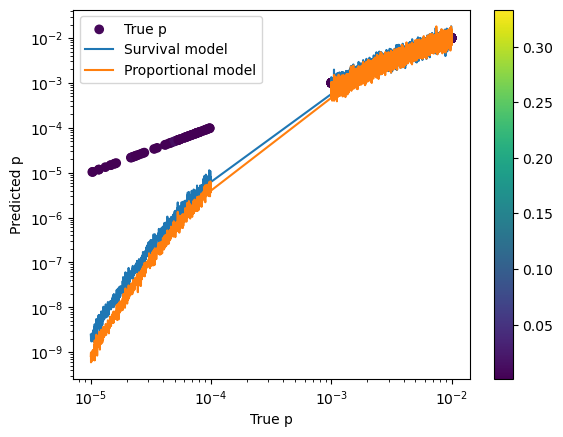

In [4]:
from matplotlib import pyplot as plt

# Print the data features - mean e, mean p, mean t_tilde, mean b, mean n_samples_random
print("Mean e:", e.mean())
print("Mean p:", p.mean())
print("Mean t_tilde:", t_tilde.mean())
print("Mean b:", b.mean())
print("Mean n_samples_random:", n_samples_random.mean())

# Print the mean predicted values
print("Mean survival model prediction:", surv_pred.mean())
print("Mean proportional model prediction:", prop_pred.mean())
# print("Mean L1 model prediction:", L1_pred.mean())
# print("Mean L2 model prediction:", L2_pred.mean())

# Plot the results
plt.figure()
plt.yscale("log")
plt.xscale("log")
empirical_pct_test = (b_test / n_samples_random_test)[sort_idx]
empirical_pct_train = (b_train / n_samples_random_train)
emp_p_train_non_zero = empirical_pct_train > 0
plt.scatter(p_train[emp_p_train_non_zero], p_train[emp_p_train_non_zero], label="True p", c=empirical_pct_train[emp_p_train_non_zero], cmap="viridis")
plt.plot(p_test, surv_pred, label="Survival model")
plt.plot(p_test, prop_pred, label="Proportional model")
# plt.plot(p_test, L1_pred, label="L1 model")
# plt.plot(p_test, L2_pred, label="L2 model")
plt.xlabel("True p")
plt.ylabel("Predicted p")
plt.legend()

# Add a colorbar
plt.colorbar()
plt.show()

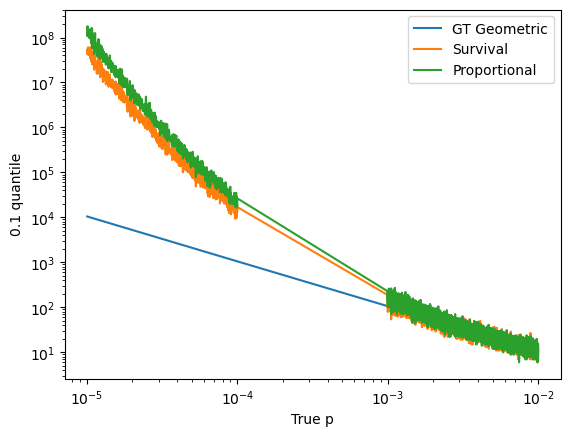

In [5]:
def quantile_estimators(preds, taus):
    return np.array([stats.geom.ppf(q, p=clip_p(preds.flatten())) for q in taus])

q_surv = quantile_estimators(surv_pred, [0.1])[0]
q_prop = quantile_estimators(prop_pred, [0.1])[0]

# Plot the results in terms of the 0.1 quantile of the Geometric distribution
plt.figure()
plt.xscale("log")
plt.yscale("log")
plt.plot(p_test, stats.geom.ppf(0.1, p=p_test), label="GT Geometric")
# plt.plot(p_test, stats.geom.ppf(0.1, p=empirical_pct_test), label="Empiric Geometric")
plt.plot(p_test, q_surv, label="Survival")
plt.plot(p_test, q_prop, label="Proportional")
# plt.plot(p_test, stats.geom.ppf(0.1, p=clip_p(L1_pred.flatten())), label="L1")
# plt.plot(p_test, stats.geom.ppf(0.1, p=clip_p(L2_pred.flatten())), label="L2")
plt.xlabel("True p")
plt.ylabel("0.1 quantile")
plt.legend()

In [6]:
def coverage(quantile_preds, p):
    return 1 - stats.geom.cdf(quantile_preds, p)


In [17]:
def get_probs(budget_per_sample, prior_quantile_est, needed_prob=1):
    C_probs = budget_per_sample/prior_quantile_est
    above = C_probs > needed_prob
    below = C_probs < needed_prob
    while above.any() and below.any():
        leftover = ((C_probs[above] - needed_prob) * prior_quantile_est[above]).sum()
        C_probs[above] = needed_prob
        below = C_probs < needed_prob
        above = C_probs > needed_prob
        # Distribute the leftover budget to the bellow one, proportionally to their prior quantile estimate
        leaftover_per_sample = leftover / below.sum()
        C_probs[below] += leaftover_per_sample / prior_quantile_est[below]
        below = C_probs < needed_prob
        above = C_probs > needed_prob
    C_probs = np.minimum(C_probs, 1)
    return C_probs


# Generate a new calibration set - each observation has a random number of samples:
def resample_calibration_set(p_cal, prior_quantile_est, C_probs):
    # Determine the number of samples per instance
    C = np.where(np.random.uniform(size=len(prior_quantile_est)) < C_probs, 
                                    prior_quantile_est, 0).astype(int)
    
    # Compute t_tilde_cal without creating large matrices
    T = np.random.geometric(p_cal, size=len(p_cal)).astype(int)
    T_tilde = np.minimum(T, C)

    return T_tilde, C

# Define the conformalizing function
def conformalize(preds, target_taus, canidate_taus, C, T_tilde, budget_per_sample, share_budget=False, min_sample_size=None, needed_prob=1):
    prior_tau = canidate_taus.max()
    # Compute the quantile estimators
    quantile_est = quantile_estimators(preds, canidate_taus).astype(int)

    prior_quantile_est = quantile_estimators(preds, [prior_tau])[0].astype(int)
    max_estimator = np.inf
    if share_budget:
        C_probs = get_probs(budget_per_sample, prior_quantile_est, needed_prob=needed_prob)
        budget_per_sample = (C_probs * prior_quantile_est)[C_probs < needed_prob].mean()
    else:
        C_probs = budget_per_sample/prior_quantile_est
        C_probs = np.minimum(C_probs, 1)
    if min_sample_size:
        max_estimator = int(budget_per_sample / min_sample_size)
        C_probs = np.maximum(C_probs, min_sample_size)
        quantile_est = np.minimum(quantile_est, max_estimator)
        prior_quantile_est = np.minimum(prior_quantile_est, max_estimator)

    # Resample the calibration set
    T_tilde, C = resample_calibration_set(p_cal, prior_quantile_est, C_probs)

    # Compute the weights - 1/conditional_probability
    weights = 1 / C_probs
    weights = np.where(quantile_est <= C, weights, 0)

    T_tilde_miscoverage = np.where(T_tilde < quantile_est, 1, 0)

    # Compute the estimated miscoverage for each quantile
    tau_hats = (weights * T_tilde_miscoverage).sum(axis=1) / weights.sum(axis=1)

    tau_diff = target_taus - tau_hats[:, np.newaxis]
    smallest_pos = np.where(tau_diff > 0, 1, -1. * np.inf).cumsum(axis=0).argmax(axis=0)
    a_hats = canidate_taus[smallest_pos]
    
    return a_hats, weights[smallest_pos], T_tilde_miscoverage[smallest_pos], max_estimator, C_probs


Conformalized survival quantile: 0.017436992144844267
Conformalized proportional quantile: 0.024926168034190347
Conformalized survival quantile with min sample size 0.05: 0.0595547475405987
Conformalized proportional quantile with min sample size 0.05: 0.04981090297452725


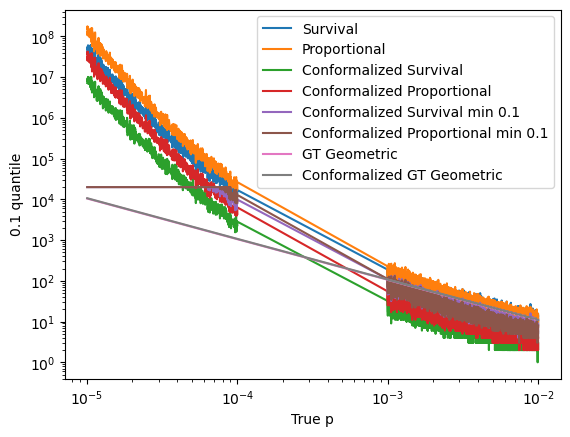

In [18]:

# Define the target quantiles
target_taus = np.array([0.1])

# Define the candidate quantiles
candidate_taus = np.logspace(-3, -0.1, 300)

# Predict the p for the calibration set
surv_pred_cal = predict(survival_model, x_cal)
prop_pred_cal = predict(prop_model, x_cal)

budget_per_sample = 2000

# Conformalize the predictions
conformalized_surv, weights_surv, T_tilde_miscoverage_surv, _, C_probs_surv = conformalize(surv_pred_cal, target_taus, candidate_taus, n_samples_random_cal, t_tilde_cal, budget_per_sample)
conformalized_prop, weights_prop, T_tilde_miscoverage_prop, _, C_probs_prop = conformalize(prop_pred_cal, target_taus, candidate_taus, n_samples_random_cal, t_tilde_cal, budget_per_sample)

# Conformalize with a minimum sample size 0.5
conformalized_surv_min, weights_surv_min, T_tilde_miscoverage_surv_min, max_est_surv, C_probs_surv_min = conformalize(surv_pred_cal, target_taus, candidate_taus, n_samples_random_cal, t_tilde_cal, budget_per_sample, min_sample_size=0.1, share_budget=False)
conformalized_prop_min, weights_prop_min, T_tilde_miscoverage_prop_min, max_est_surv, C_probs_prop_min = conformalize(prop_pred_cal, target_taus, candidate_taus, n_samples_random_cal, t_tilde_cal, budget_per_sample, min_sample_size=0.1, share_budget=False)

conformalized_surv = conformalized_surv[0]
conformalized_prop = conformalized_prop[0]
conformalized_surv_min = conformalized_surv_min[0]
conformalized_prop_min = conformalized_prop_min[0]

print(f"Conformalized survival quantile: {conformalized_surv}")
print(f"Conformalized proportional quantile: {conformalized_prop}")
print(f"Conformalized survival quantile with min sample size 0.05: {conformalized_surv_min}")
print(f"Conformalized proportional quantile with min sample size 0.05: {conformalized_prop_min}")

# Predict the quantiles for the test set
q_surv_conf = quantile_estimators(surv_pred, [conformalized_surv])[0].astype(int)
q_prop_conf = quantile_estimators(prop_pred, [conformalized_prop])[0].astype(int)
q_surv_conf_min = np.minimum(quantile_estimators(surv_pred, [conformalized_surv_min])[0], max_est_surv).astype(int)
q_prop_conf_min = np.minimum(quantile_estimators(prop_pred, [conformalized_prop_min])[0], max_est_surv).astype(int)

# Get the ground truth quantiles
q_gt = stats.geom.ppf(0.1, p=p_test).astype(int)

# Conformalize the ground truth
conformalized_gt, weights_gt, _, _, C_probs_gt = conformalize(p_cal, target_taus, candidate_taus, n_samples_random_cal, t_tilde_cal, budget_per_sample)

# Predict the conformalized quantiles
q_gt_conf = quantile_estimators(p_test, conformalized_gt)[0].astype(int)

# Plot the conformalized quantiles
plt.figure()
plt.xscale("log")
plt.yscale("log")
plt.plot(p_test, q_surv, label="Survival")
plt.plot(p_test, q_prop, label="Proportional")
plt.plot(p_test, q_surv_conf, label="Conformalized Survival")
plt.plot(p_test, q_prop_conf, label="Conformalized Proportional")
plt.plot(p_test, q_surv_conf_min, label="Conformalized Survival min 0.1")
plt.plot(p_test, q_prop_conf_min, label="Conformalized Proportional min 0.1")
plt.plot(p_test, q_gt, label="GT Geometric")
plt.plot(p_test, q_gt_conf, label="Conformalized GT Geometric")
plt.xlabel("True p")
plt.ylabel("0.1 quantile")
plt.legend()

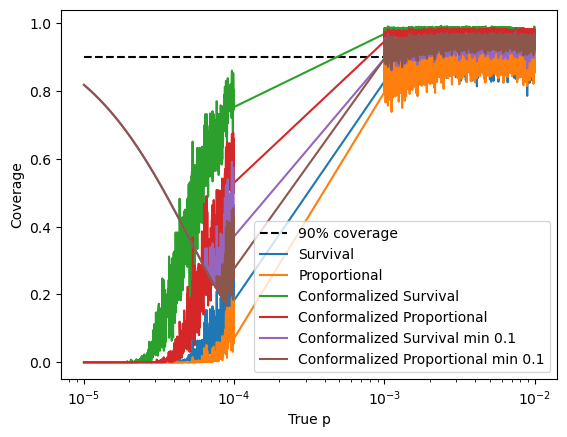

In [ ]:
# Plot the coverage of the the predicted 0.1 quantile
plt.figure()
plt.xscale("log")
plt.hlines(0.9, p_test.min(), p_test.max(), label="90% coverage", color="black", linestyle="--")
plt.plot(p_test, coverage(q_surv, p=p_test), label="Survival")
plt.plot(p_test, coverage(q_prop, p=p_test), label="Proportional")
plt.plot(p_test, coverage(q_surv_conf, p=p_test), label="Conformalized Survival")
plt.plot(p_test, coverage(q_prop_conf, p=p_test), label="Conformalized Proportional")
plt.plot(p_test, coverage(q_surv_conf_min, p=p_test), label="Conformalized Survival min 0.1")
plt.plot(p_test, coverage(q_prop_conf_min, p=p_test), label="Conformalized Proportional min 0.1")
plt.xlabel("True p")
plt.ylabel("Coverage")
plt.legend()

In [20]:
# Print mean coverage and mean quantile value for each model
print("Survival model mean coverage:", coverage(q_surv, p=p_test).mean())
print("Proportional model mean coverage:", coverage(q_prop, p=p_test).mean())
print("Conformalized survival model mean coverage:", coverage(q_surv_conf, p=p_test).mean())
print("Conformalized proportional model mean coverage:", coverage(q_prop_conf, p=p_test).mean())
print("Conformalized survival model min 0.1 mean coverage:", coverage(q_surv_conf_min, p=p_test).mean())
print("Conformalized proportional model min 0.1 mean coverage:", coverage(q_prop_conf_min, p=p_test).mean())

Survival model mean coverage: 0.810198311975306
Proportional model mean coverage: 0.8011997313603999
Conformalized survival model mean coverage: 0.9082187239063373
Conformalized proportional model mean coverage: 0.8867394067754049
Conformalized survival model min 0.1 mean coverage: 0.8964015168743419
Conformalized proportional model min 0.1 mean coverage: 0.9007478584439894


In [21]:
# Conformalize 100 times and plot violin plots
import tqdm

n_conformalizations = 20
mean_coverages_prop = [coverage(q_prop, p=p_test).mean()]
mean_LPB_prop = [q_prop.mean()]
mean_coverages_prop_conf = []
mean_LPB_prop_conf = []
mean_coverages_prop_conf_min = []
mean_LPB_prop_conf_min = []
mean_coverages_prop_conf_min_shared = []
mean_LPB_prop_conf_min_shared = []
for i in tqdm.tqdm(range(n_conformalizations)):
    conformalized_prop, weights_prop, T_tilde_miscoverage_prop, _, _ = conformalize(prop_pred_cal, target_taus, candidate_taus, n_samples_random_cal, t_tilde_cal, budget_per_sample)
    conformalized_prop_min, weights_prop_min, T_tilde_miscoverage_prop_min, max_est_surv, _ = conformalize(prop_pred_cal, target_taus, candidate_taus, n_samples_random_cal, t_tilde_cal, budget_per_sample, min_sample_size=0.1)
    conformalized_prop_min_shared, weights_prop_min_shared, T_tilde_miscoverage_prop_min_shared, max_est_surv_shared, _ = conformalize(prop_pred_cal, target_taus, candidate_taus, n_samples_random_cal, t_tilde_cal, budget_per_sample, min_sample_size=0.1, share_budget=True)
    q_prop_conf = quantile_estimators(prop_pred, [conformalized_prop])[0].astype(int)
    q_prop_conf_min = np.minimum(quantile_estimators(prop_pred, [conformalized_prop_min])[0], max_est_surv).astype(int)
    q_prop_conf_min_shared = np.minimum(quantile_estimators(prop_pred, [conformalized_prop_min_shared])[0], max_est_surv_shared).astype(int)
    mean_coverages_prop_conf.append(coverage(q_prop_conf, p=p_test).mean())
    mean_LPB_prop_conf.append(q_prop_conf.mean())
    mean_coverages_prop_conf_min.append(coverage(q_prop_conf_min, p=p_test).mean())
    mean_LPB_prop_conf_min.append(q_prop_conf_min.mean())
    mean_coverages_prop_conf_min_shared.append(coverage(q_prop_conf_min_shared, p=p_test).mean())
    mean_LPB_prop_conf_min_shared.append(q_prop_conf_min_shared.mean())

100%|██████████| 20/20 [00:48<00:00,  2.40s/it]


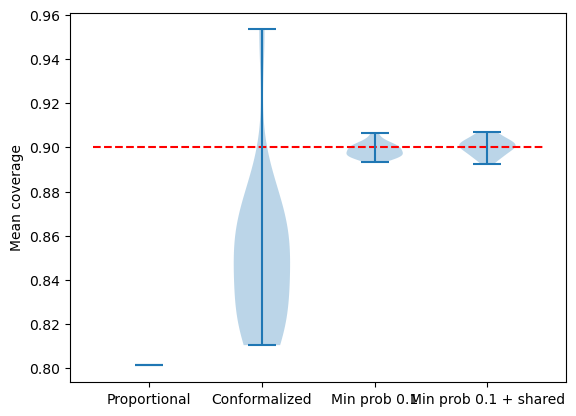

Mean coverage proportional model: 0.8011997313603999
Mean coverage conformalized proportional model: 0.8500750378604538
Mean coverage conformalized proportional model min 0.1: 0.8986810768828152
Mean coverage conformalized proportional model min 0.1 shared: 0.9003084948720035


In [22]:
plt.figure()
plt.hlines(0.9, 0.5, 4.5, label="90% coverage", color="red", linestyle="--")
plt.violinplot([mean_coverages_prop, mean_coverages_prop_conf, mean_coverages_prop_conf_min, mean_coverages_prop_conf_min_shared])
plt.xticks([1, 2, 3, 4], ["Proportional","Conformalized", "Min prob 0.1", "Min prob 0.1 + shared"])
plt.ylabel("Mean coverage")
plt.show()

# Print the mean coverages
print("Mean coverage proportional model:", np.mean(mean_coverages_prop))
print("Mean coverage conformalized proportional model:", np.mean(mean_coverages_prop_conf))
print("Mean coverage conformalized proportional model min 0.1:", np.mean(mean_coverages_prop_conf_min))
print("Mean coverage conformalized proportional model min 0.1 shared:", np.mean(mean_coverages_prop_conf_min_shared))

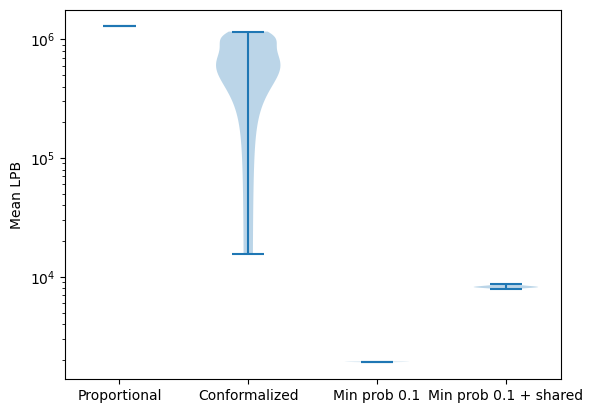

In [25]:
plt.figure()
plt.violinplot([mean_LPB_prop, mean_LPB_prop_conf, mean_LPB_prop_conf_min, mean_LPB_prop_conf_min_shared])
plt.xticks([1, 2, 3, 4], ["Proportional","Conformalized", "Min prob 0.1", "Min prob 0.1 + shared"])
plt.ylabel("Mean LPB")
plt.yscale("log")
plt.show()

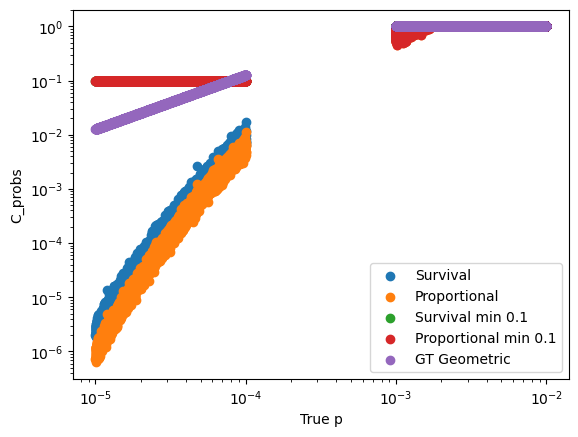

In [24]:
# Sort p_cal and the C_probs
sort_idx = np.argsort(p_cal)
p_cal_sorted = p_cal[sort_idx]
C_probs_surv_sorted = C_probs_surv[sort_idx]
C_probs_prop_sorted = C_probs_prop[sort_idx]
C_probs_surv_min_sorted = C_probs_surv_min[sort_idx]
C_probs_prop_min_sorted = C_probs_prop_min[sort_idx]
C_probs_gt_sorted = C_probs_gt[sort_idx]

# Plot the C_probs
plt.figure()
plt.xscale("log")
plt.yscale("log")
plt.scatter(p_cal_sorted, C_probs_surv_sorted, label="Survival")
plt.scatter(p_cal_sorted, C_probs_prop_sorted, label="Proportional")
plt.scatter(p_cal_sorted, C_probs_surv_min_sorted, label="Survival min 0.1")
plt.scatter(p_cal_sorted, C_probs_prop_min_sorted, label="Proportional min 0.1")
plt.scatter(p_cal_sorted, C_probs_gt_sorted, label="GT Geometric")
plt.xlabel("True p")
plt.ylabel("C_probs")
plt.legend()

# sort_idx = np.argsort(p_cal)
# p_cal_sorted = p_cal[sort_idx]
# weights_surv_sorted = weights_surv.flatten()[sort_idx]
# non_zero_surv = weights_surv_sorted > 0
# weights_prop_sorted = weights_prop.flatten()[sort_idx]
# non_zero_prop = weights_prop_sorted > 0
# weights_surv_min_sorted = weights_surv_min.flatten()[sort_idx]
# non_zero_surv_min = weights_surv_min_sorted > 0
# weights_prop_min_sorted = weights_prop_min.flatten()[sort_idx]
# non_zero_prop_min = weights_prop_min_sorted > 0
# weights_gt_sorted = weights_gt.flatten()[sort_idx]
# non_zero_gt = weights_gt_sorted > 0

# Plot the sliding window average of the weights
# plt.figure()
# plt.xscale("log")
# plt.plot(p_cal_sorted[non_zero_surv], np.convolve(weights_surv_sorted[non_zero_surv], np.ones(100)/100, mode="same"), label="Survival")
# plt.plot(p_cal_sorted[non_zero_prop], np.convolve(weights_prop_sorted[non_zero_prop], np.ones(100)/100, mode="same"), label="Proportional")
# plt.plot(p_cal_sorted[non_zero_surv_min], np.convolve(weights_surv_min_sorted[non_zero_surv_min], np.ones(100)/100, mode="same"), label="Survival min 0.1")
# plt.plot(p_cal_sorted[non_zero_prop_min], np.convolve(weights_prop_min_sorted[non_zero_prop_min], np.ones(100)/100, mode="same"), label="Proportional min 0.1")
# plt.plot(p_cal_sorted[non_zero_gt], np.convolve(weights_gt_sorted[non_zero_gt], np.ones(100)/100, mode="same"), label="GT Geometric")
# plt.xlabel("True p")
# plt.ylabel("Weights")
# plt.legend()

# plt.figure()
# plt.xscale("log")
# plt.yscale("log")
# plt.scatter(p_cal, weights_surv, label="Survival")
# plt.scatter(p_cal, weights_prop, label="Proportional")
# plt.scatter(p_cal, weights_surv_min, label="Survival min 0.1")
# plt.scatter(p_cal, weights_prop_min, label="Proportional min 0.1")
# plt.scatter(p_cal, weights_gt, label="GT Geometric")
# plt.xlabel("True p")
# plt.ylabel("Weights")
# plt.legend()